In [1]:
import sys
#Install packages prefer conda if you are using anaconda otherwise try with pip, uncomment only if install is needed (if you use Google colab pip should work)

#conda:
#os.system('conda install GPy -c conda-forge')
#os.system('conda install GPyOpt -c conda-forge')

#pip:
#!{sys.executable} -m pip install GPy
#!{sys.executable} -m pip install GPyOpt
import numpy as np
import matplotlib.pyplot as plt
#import GPyOpt
from torchvision import datasets, transforms, utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV, cross_val_score
from scipy.stats import uniform
import random
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import torch
# Models
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils import resample
#one hot encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Score Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

from tqdm import tqdm
#plot spectrogram
from matplotlib.pyplot import specgram

from scipy import stats
#mixup
import random
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
#from mixup import mix, mixupreg, converttohardlabel
#from mixup import mix

#CM
from sklearn.metrics import confusion_matrix
np.random.seed(32)
random.seed(32)

In [2]:
# Mixing two training data points and returning the mixed data point and its label between 0 and 1
def mix(eeg_info_1=None, eeg_info_2=None, lambd=None):

    X1, X2 = eeg_info_1["eeg"], eeg_info_2["eeg"]

    y1, y2 = eeg_info_1["label"], eeg_info_2["label"]

    mix_X = X1 * lambd + X2 * (1. - lambd)

    label = y1 * lambd + y2 * (1. - lambd)

    return mix_X, label

In [47]:
# Takes a training set (and labels) as input and returns a modifed training set, where the mixup augmentations have been
# added
def mixup(X_train=None, y_train=None, size=None, method='split'):
    # Number of mixup augmentation examples - default is
    N = int(len(y_train)/10) if not size or size > len(y_train) else size

    # If method is 'split' we need 10 extra examples per mixed example, since we will generate 10 new
    # examples for each mixup data point
    factor = 10 if method == 'split' else 1

    mix_Xs = np.zeros((N * factor, len(X_train[0])))
    mix_ys = np.zeros(N * factor)

    # choose mixup batch randomly from the training data
    indices = np.random.permutation(len(X_train))[:N * 2 * factor]

    # Choose indicies from different classes instead

    ind1 = np.random.permutation(np.where(y_train == 0)[0])[:N * factor]
    ind2 = np.random.permutation(np.where(y_train == 1)[0])[:N * factor]

    print(indices.shape, ind1.shape, ind2.shape)

    N2 = int(len(indices)/2) if N >= len(y_train)/2 else N

    print(indices[:N2].shape, ind1.shape, ind2.shape)

    X_1, X_2 = X_train[indices[:N2]], X_train[indices[N2:]]
    y_1, y_2 = y_train[indices[:N2]], y_train[indices[N2:]]
    print(X_1.shape, y_1.shape)

    #X_1, X_2 = X_train[ind1[:N2]], X_train[ind2[N2:]]
    #y_1, y_2 = y_train[ind1[:N2]], y_train[ind2[N2:]]
    print(X_1.shape, y_1.shape)

    for i in range(len(y_1)):

        data_info_1, data_info_2 = {"data": X_1[i], "label": y_1[i]}, {"data": X_2[i], "label": y_2[i]}
        lambd = np.random.uniform(0, 1)
        mix_X, label = mix(data_info_1=data_info_1, data_info_2=data_info_2, lambd=lambd)

        if method == 'split':
            # Add 10 identical instances of each mixup augmented data point
            for j in range(10):
                mix_Xs[10 * i + j, :] = mix_X
                mix_ys[10 * i + j] = data_info_1['label'] if j + 1 <= int(round(lambd, 0))*10 else data_info_2['label']

        # Assign label to the original label which were weighted higher in the generation og the new X point
        elif method == 'largest':
            mix_Xs[i] = mix_X
            mix_ys[i] = data_info_1['label'] if lambd >= 0.5 else data_info_2['label']

        # Sample the final label where each probability for a label corresponds to how much it has been weighted in the
        # mixup
        elif method == 'sample':
            mix_ys[i] = np.random.choice([data_info_1["label"], data_info_2["label"]], 1, p=[lambd, 1.-lambd])

    # Add mixups to training set
    X_train_mixup, y_train_mixup = np.concatenate([mix_Xs, X_train]), np.concatenate([mix_ys, y_train])

    # Shuffle the data and the new mixup augmentations before returning
    shuffler = np.random.permutation(len(X_train_mixup))
    X_train_mixup, y_train_mixup = X_train_mixup[shuffler], y_train_mixup[shuffler]

    return X_train_mixup, y_train_mixup

In [3]:
def mixupreg(X_train = None, y_train = None, size = None, alpha = None):
    # Number of mixup augmentation examples - default is
    #N = int(len(y_train) / 10) if not size or size > len(y_train) else size
    N = size
    N2 = int(N/2)
    print(N2)
   
    # If method is 'split' we need 10 extra examples per mixed example, since we will generate 10 new
    # examples for each mixup data point


    mix_Xs = np.zeros((N2, np.size(X_train, 1)))
    mix_ys = np.zeros((N2, np.size(y_train, 1)))

    # choose mixup batch randomly from the training data
    #indices = np.random.permutation(len(X_train))[:N * 2]

    #N2 = int(len(indices) / 2) if N >= np.size(y_train, 0) / 2 else N
    
    X_1, X_2 = X_train[:N2], X_train[N2:2*N2]
    y_1, y_2 = y_train[:N2], y_train[N2:2*N2]
    print(y_1.shape, y_2.shape)
    #X_1, X_2 = X_train[indices[:N2]], X_train[indices[N2:]]
    #y_1, y_2 = y_train[indices[:N2]], y_train[indices[N2:]]
    #print(y_train.shape(), y_1.shape())

    
   
    for i in range(len(y_1)):
        eeg_info_1, eeg_info_2 = {"eeg": X_1[i], "label": y_1[i]}, {"eeg": X_2[i], "label": y_2[i]}
        #lambd = np.random.uniform(0.1, 0.4)  # must be beta
        lambd = np.random.beta(alpha, alpha) 
        print(lambd)
        mix_X, mix_y = mix(eeg_info_1=eeg_info_1, eeg_info_2=eeg_info_2, lambd=lambd)
        mix_Xs[i] = mix_X
        mix_ys[i] = mix_y
    #print(mix_ys)

    return mix_Xs, mix_ys

In [4]:
def converttohardlabel(y_pred_mix, method=''):

    y_pred_mix_hard = np.zeros((np.size(y_pred_mix,0),np.size(y_pred_mix,1)))

    if method == 'Maximum likelihood':
        for i in range(len(y_pred_mix)):  # loop over rows

        
            if np.argmax(y_pred_mix, axis=1)[i] == 4:
                y_pred_mix_hard[i] = [0, 0, 0, 0 ,1]

            elif np.argmax(y_pred_mix, axis=1)[i] == 3:
                y_pred_mix_hard[i] = [0, 0, 0, 1, 0]
                
            elif np.argmax(y_pred_mix, axis=1)[i] == 2:
                y_pred_mix_hard[i] = [0, 0, 1, 0, 0]
            
            elif np.argmax(y_pred_mix, axis=1)[i] == 1:
                y_pred_mix_hard[i] = [0, 1, 0, 0, 0]

            elif np.argmax(y_pred_mix, axis=1)[i] == 0:
                y_pred_mix_hard[i] = [1, 0, 0, 0, 0]
                
            else:
                print(y_pred_mix[i])

    return y_pred_mix_hard

In [6]:
def load_MNIST():
    '''
    Function to load the MNIST training and test set with corresponding labels.

    :return: training_examples, training_labels, test_examples, test_labels
    '''

    # we want to flat the examples

    train_data = datasets.MNIST(root='./data', train=True, transform=None,download=True)
    test_data = datasets.MNIST(root='./data', train=False, transform=None,download=True)
    
    Xtrain = train_data.data.numpy().reshape(-1,28*28)
    Xtest = test_data.data.numpy().reshape(-1,28*28)

    ytrain = train_data.targets.numpy()
    ytest = test_data.targets.numpy()
    return Xtrain, ytrain, Xtest, ytest

In [7]:
## we can load the training set and test set
Xtrain, ytrain, Xtest, ytest  = load_MNIST()

Xtrain_copy, ytrain_copy, Xtest_copy, ytest_copy = Xtrain, ytrain, Xtest, ytest

In [8]:
np.shape(Xtrain), np.shape(ytrain), np.shape(Xtest), np.shape(ytest)

((60000, 784), (60000,), (10000, 784), (10000,))

In [9]:
## since training a random forest on the entire dataset takes some time
## we can consider only few labels, like 3, 5, 8 and 9


## we use a mask to selects those subsets
train_filter = np.isin(ytrain, [0,1,2,3,4])
test_filter = np.isin(ytest, [0,1,2,3,4])

# apply the mask to the entire dataset
Xtrain, ytrain = Xtrain[train_filter], ytrain[train_filter]
Xtest, ytest = Xtest[test_filter], ytest[test_filter]

# print some information
print('Information about the new datasets')
print('Training set shape:', Xtrain.shape)
print('Test set shape', Xtest.shape)

Information about the new datasets
Training set shape: (30596, 784)
Test set shape (5139, 784)


In [10]:
N = 500
zeros, ones, twos, threes, fours = np.where(ytrain==0)[0], np.where(ytrain==1)[0], np.where(ytrain==2)[0], np.where(ytrain==3)[0], np.where(ytrain==4)[0]
print(len(zeros), len(ones), len(twos), len(threes), len(fours))
zeros, ones, twos, threes, fours = zeros[:N], ones[:N], twos[:N], threes[:N], fours[:N]

ind = np.concatenate((zeros, ones, twos, threes, fours))

Xtrain, ytrain = Xtrain[ind], ytrain[ind]

#shuffler = np.random.permutation(len(Xtrain))
#Xtrain, ytrain = Xtrain[shuffler], ytrain[shuffler]
Xtrain, ytrain = shuffle(Xtrain, ytrain)
Xtest, ytest = shuffle(Xtest, ytest)
#shuffler2 = np.random.permutation(len(Xtest))
#Xtest, ytest = Xtest[shuffler2], ytest[shuffler2]

#Xtrain = [Xtrain[i] + np.random.rand for i in range(len(Xtrain))]
# print some information
#standardize
scaler = StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

print('Information about the new datasets')
print('Training set shape:', Xtrain.shape)
print('Test set shape', Xtest.shape)
print(ytrain.shape, ytest.shape)

5923 6742 5958 6131 5842
Information about the new datasets
Training set shape: (2500, 784)
Test set shape (5139, 784)
(2500,) (5139,)


In [11]:
len(zeros), len(ones), len(twos), len(threes), len(fours)

(500, 500, 500, 500, 500)

In [55]:
#select only ones zeros twos DONT RUN
'''
N = 100
zeros, ones, twos = np.where(ytrain==0)[0], np.where(ytrain==1)[0], np.where(ytrain==2)[0]
zeros, ones, twos = zeros[:N], ones[:N], twos[:N]
ind = np.concatenate((zeros, ones, twos))

Xtrain, ytrain = Xtrain[ind], ytrain[ind]

shuffler = np.random.permutation(len(Xtrain))
Xtrain, ytrain = Xtrain[shuffler], ytrain[shuffler]

#test data
zero, one, two = np.where(ytest==0)[0], np.where(ytest==1)[0], np.where(ytest==2)[0]

indx = np.concatenate((zero, one, two))

Xtest, ytest = Xtest[indx], ytest[indx]

shuffler2 = np.random.permutation(len(Xtest))
Xtest, ytest = Xtest[shuffler2], ytest[shuffler2]


# print some information
print('Information about the new datasets')
print('Training set shape:', Xtrain.shape)
print('Test set shape', Xtest.shape)
print(ytrain.shape, ytest.shape)
'''

"\nN = 100\nzeros, ones, twos = np.where(ytrain==0)[0], np.where(ytrain==1)[0], np.where(ytrain==2)[0]\nzeros, ones, twos = zeros[:N], ones[:N], twos[:N]\nind = np.concatenate((zeros, ones, twos))\n\nXtrain, ytrain = Xtrain[ind], ytrain[ind]\n\nshuffler = np.random.permutation(len(Xtrain))\nXtrain, ytrain = Xtrain[shuffler], ytrain[shuffler]\n\n#test data\nzero, one, two = np.where(ytest==0)[0], np.where(ytest==1)[0], np.where(ytest==2)[0]\n\nindx = np.concatenate((zero, one, two))\n\nXtest, ytest = Xtest[indx], ytest[indx]\n\nshuffler2 = np.random.permutation(len(Xtest))\nXtest, ytest = Xtest[shuffler2], ytest[shuffler2]\n\n\n# print some information\nprint('Information about the new datasets')\nprint('Training set shape:', Xtrain.shape)\nprint('Test set shape', Xtest.shape)\nprint(ytrain.shape, ytest.shape)\n"

In [12]:
ohe = OneHotEncoder()
ohe.fit([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]])
ytrain = ohe.transform(ytrain.reshape(-1,1)).toarray()
ytest = ohe.transform(ytest.reshape(-1,1)).toarray()
ytrain = np.delete(ytrain, [5,6,7,8,9], 1)
ytest = np.delete(ytest, [5,6,7,8,9], 1)
np.shape(ytrain), np.shape(ytest), np.shape(Xtrain), np.shape(Xtest)

((2500, 5), (5139, 5), (2500, 784), (5139, 784))

In [13]:
model = MLPRegressor(activation='logistic')
model.fit(Xtrain, ytrain)

ypred = model.predict(Xtest)
ypred

array([[ 6.27057176e-03, -9.46747033e-02,  9.91005581e-01,
        -1.94560898e-01,  1.12033233e-01],
       [ 3.32051502e-02,  1.10891238e-01,  9.49523065e-01,
         2.13005080e-01, -1.79451898e-01],
       [-6.77075942e-02, -1.08616870e-01,  2.77762832e-01,
         9.66313453e-01, -3.09287731e-02],
       ...,
       [ 5.69633777e-02,  9.73150948e-01,  9.74694109e-03,
         2.49957605e-02, -8.36515213e-04],
       [ 3.84607555e-01,  1.32043986e-01, -5.75553304e-01,
         4.69848075e-01,  5.31870569e-01],
       [-3.18009256e-03,  4.65484225e-02,  9.70346122e-01,
         3.93610448e-02, -1.58142394e-01]])

In [14]:


stats.describe(ypred)

DescribeResult(nobs=5139, minmax=(array([-0.59746729, -0.42113331, -1.25322208, -0.84754297, -0.52784616]), array([1.15465779, 1.1628181 , 1.46562661, 1.3419561 , 1.32058546])), mean=array([0.19032495, 0.2253947 , 0.19640031, 0.19027657, 0.19275434]), variance=array([0.14821717, 0.1694918 , 0.1385735 , 0.14177176, 0.14261189]), skewness=array([1.43015707, 1.23020039, 1.40411576, 1.37883989, 1.38600841]), kurtosis=array([ 0.42194335, -0.213387  ,  0.61680182,  0.47037932,  0.39295419]))

In [15]:
y_pred_classes = ypred.argmax(1)
y_test_classes = ytest.argmax(1)
y_test_classes, y_pred_classes

(array([2, 2, 3, ..., 1, 3, 2]), array([2, 2, 3, ..., 1, 4, 2]))

In [60]:
'''#convert to hard labels
ypred_hard = converttohardlabel(ypred, method = 'Maximum likelihood')
ypred_hard

#convert them to categorical classes
y_pred_classes = ypred_hard.argmax(1)
y_test_classes = ytest.argmax(1)
y_pred_classes, y_test_classes, ypred_hard'''

"#convert to hard labels\nypred_hard = converttohardlabel(ypred, method = 'Maximum likelihood')\nypred_hard\n\n#convert them to categorical classes\ny_pred_classes = ypred_hard.argmax(1)\ny_test_classes = ytest.argmax(1)\ny_pred_classes, y_test_classes, ypred_hard"

In [61]:
#np.count_nonzero(ypred_hard[:,0] == 1) + np.count_nonzero(ypred_hard[:,1] == 1) + np.count_nonzero(ypred_hard[:,2] == 1)+ np.count_nonzero(ypred_hard[:,3] == 1, np.count_nonzero(ypred_hard[:,4] == 1))

In [16]:
print('model without mixup: ', model)
#print("Train data: Accuracy:", np.mean(model.predict(X_train_mix) == y_train_mix) * 100)

print("Test data: Accuracy:", np.mean(y_pred_classes == y_test_classes) * 100)
print("Test data: Balanced accuracy:", balanced_accuracy_score(y_test_classes, y_pred_classes) * 100)
#print("Test data: F1-Score:", f1_score(y_test, y_pred_hard_mix) * 100)
print("Test: Weighted F1-Score:", round(f1_score(y_test_classes, y_pred_classes, average='weighted') * 100, 3), '%')
print()
print(classification_report(y_test_classes, y_pred_classes))
print()
#print('Default model out of bag error', model.oob_score_)
#print('Default model train accuracy', model.score(Xtrain, ytrain))
#print('Default model test accuracy', model.score(Xtest, ytest))

model without mixup:  MLPRegressor(activation='logistic')
Test data: Accuracy: 97.08114419147694
Test data: Balanced accuracy: 97.07141939370626
Test: Weighted F1-Score: 97.074 %

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.93      0.95      1032
           3       0.97      0.96      0.96      1010
           4       0.96      0.98      0.97       982

    accuracy                           0.97      5139
   macro avg       0.97      0.97      0.97      5139
weighted avg       0.97      0.97      0.97      5139




In [17]:
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((2500, 784), (2500, 5), (5139, 784), (5139, 5))

In [19]:
#add mixup to the training set
#X_train_mix, y_train_mix = mixupreg(X_train_res, y_train_res, 100)
mix_Xs, mix_ys = mixupreg(Xtrain, ytrain, 1800, alpha = 0.4)
# Add mixups to training set
X_train_mix, y_train_mix = np.concatenate([mix_Xs, Xtrain]), np.concatenate([mix_ys, ytrain])

# Shuffle the data and the new mixup augmentations before returning
#shuffler = np.random.permutation(len(X_train_mix))
#X_train_mix, y_train_mix = X_train_mix[shuffler], y_train_mix[shuffler]
#X_train_mix, y_train_mix = shuffle(X_train_mix, y_train_mix)
mixind  = np.where(y_train_mix == mix_ys)
scaler2 = StandardScaler().fit(X_train_mix)
X_train_mix = scaler2.transform(X_train_mix)
X_test_mix = scaler2.transform(Xtest)

900
(900, 5) (900, 5)
0.04608228347954197
0.973816984079477
0.11453004610609101
0.9999997016592429
0.10712050821034966
0.39119430706732855
0.18794293350783944
0.0005952991853234639
0.5417056613059121
0.8021393675508866
0.12836008031185311
0.04409950401773886
0.967191839993274
0.07486629330872976
0.0031333674472671384
0.6474913767538086
0.846088876126586
0.3974040924096407
0.045176657707873866
0.03815970012070691
0.048427399996075995
0.9993182720590318
0.9746419254468767
0.6631855565392402
0.08735845268885478
0.9988422349423329
0.7176323606688504
0.11978343726629974
0.0010702570366255197
0.8209500653105672
0.0005037186081113137
0.000579592245152521
0.9531710630207064
0.7294376237735684
0.3157497758309762
0.9973046589044325
0.9922219489067668
0.660957540649593
0.8596265937912629
0.022395954642092212
0.2872891389413318
0.7046780260056849
0.0030348165074801843
0.009857316104607206
0.7278309151554658
0.42565806089017344
0.8934398604396245
0.02341662820415181
0.1238815553682025
0.00204628442

<ipython-input-19-bfa177433d7a>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mixind  = np.where(y_train_mix == mix_ys)


In [20]:
mix_ys

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 9.73816984e-01, 0.00000000e+00, 2.61830159e-02,
        0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.15532416e-03,
        9.92844676e-01],
       [9.97595468e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.40453156e-03],
       [0.00000000e+00, 1.07775114e-04, 0.00000000e+00, 0.00000000e+00,
        9.99892225e-01]])

In [21]:
Xtrain.shape

(2500, 784)

In [22]:
model.fit(X_train_mix, y_train_mix)

ypred_mix = model.predict(X_test_mix)
ypred_mix

array([[-1.59169740e-04,  2.48570226e-02,  8.44249616e-01,
        -7.06884813e-02,  1.02377232e-01],
       [-8.14797020e-02,  5.44963810e-02,  7.97392946e-01,
         2.15811968e-01, -4.11854728e-02],
       [ 8.64672128e-02, -2.04829094e-01,  1.86423650e-01,
         9.64434296e-01,  1.56541346e-01],
       ...,
       [ 5.65170068e-02,  9.12833550e-01, -1.39047618e-02,
        -3.91171711e-02,  1.39598263e-03],
       [ 4.43114587e-01,  2.75160352e-01, -5.20231611e-01,
         2.36630672e-01,  5.61446051e-01],
       [-1.05443438e-01,  7.43710925e-02,  9.19722595e-01,
         5.33648381e-02,  8.71065496e-02]])

In [23]:
#convert to hard labels
ypred_hard_mix = converttohardlabel(ypred_mix, method = 'Maximum likelihood')
ypred_hard_mix

#convert them to categorical classes
y_pred_classes_mix = ypred_hard_mix.argmax(1)

y_pred_classes_mix, y_test_classes, ypred_hard_mix

(array([2, 2, 3, ..., 1, 4, 2]),
 array([2, 2, 3, ..., 1, 3, 2]),
 array([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.]]))

In [24]:
np.count_nonzero(ypred_hard_mix[:,0] == 1) + np.count_nonzero(ypred_hard_mix[:,1] == 1) + np.count_nonzero(ypred_hard_mix[:,2] == 1)

3113

In [25]:
np.where(y_pred_classes_mix == 1), np.where(y_test_classes == 1)
np.where(y_pred_classes_mix != y_test_classes)
y_pred_classes_mix[2], y_test_classes[2], ytest[2]

(3, 3, array([0., 0., 0., 1., 0.]))

In [26]:
print('model with mixup: ', model)
#print("Train data: Accuracy:", np.mean(model.predict(X_train_mix) == y_train_mix) * 100)

print("Test data: Accuracy:", np.mean(y_pred_classes_mix == y_test_classes) * 100)
print("Test data: Balanced accuracy:", balanced_accuracy_score(y_test_classes, y_pred_classes_mix) * 100)
#print("Test data: F1-Score:", f1_score(y_test, y_pred_hard_mix) * 100)
print("Test: Weighted F1-Score:", round(f1_score(y_test_classes, y_pred_classes_mix, average='weighted') * 100, 3), '%')
print()
print(classification_report(y_test_classes, y_pred_classes_mix))
print()

model with mixup:  MLPRegressor(activation='logistic')
Test data: Accuracy: 97.12006226892392
Test data: Balanced accuracy: 97.10646683235359
Test: Weighted F1-Score: 97.11 %

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.93      0.95      1032
           3       0.96      0.97      0.96      1010
           4       0.96      0.99      0.97       982

    accuracy                           0.97      5139
   macro avg       0.97      0.97      0.97      5139
weighted avg       0.97      0.97      0.97      5139




0 [1. 0. 0. 0. 0.]
(2500, 2) (2500,)


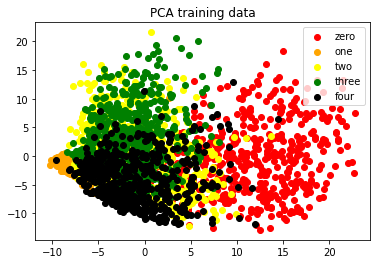

"plt.scatter(train[:,0], train[:,1], c= y)\nplt.title('PCA training data')\nplt.legend( ['0','1','2','3','4'])\nplt.show()"

In [141]:
#PCA plot
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
train = pca.fit_transform(Xtrain)
y = np.argmax(ytrain, axis = 1)
print(y[0], ytrain[0])
print(train.shape, y.shape)
#plot

z,o,t,th,f = train[y ==0], train[y ==1], train[y ==2], train[y ==3], train[y ==4]

#m = plt.scatter(trainmix[900:,0], trainmix[900:,1], c= ymix[900:])

p0 = plt.scatter(z[:,0], z[:,1], marker='o', color='red')
p1 = plt.scatter(o[:,0], o[:,1], marker='o', color='orange')
p2 = plt.scatter(t[:,0], t[:,1], marker='o', color='yellow')
p3 = plt.scatter(th[:,0], th[:,1], marker='o', color='green')
p4 = plt.scatter(f[:,0], f[:,1], marker='o', color='black')

#plt.scatter(mixup[:,0], mixup[:,1], marker='x', color='b')
plt.title('PCA training data')
plt.legend((p0,p1,p2,p3,p4),( 'zero', 'one','two','three','four'))
plt.show()


'''plt.scatter(train[:,0], train[:,1], c= y)
plt.title('PCA training data')
plt.legend( ['0','1','2','3','4'])
plt.show()'''

(array([], dtype=int64),)
0 [1. 0. 0. 0. 0.]
(3400, 2) (3400,)


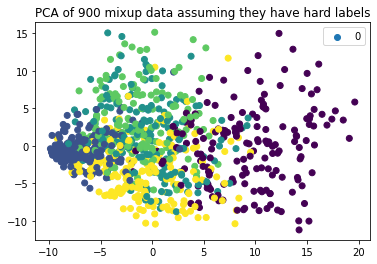

In [121]:
'''#PCA plot
trainmix = pca.fit_transform(X_train_mix)
ymix = np.argmax(y_train_mix, 1)
print(ymix[0], y_train_mix[0])
print(trainmix.shape, ymix.shape)
#plot
'''col = [0]*len(ymix)
np.where()
col = np.where(ymix<1,'k',np.where(y<5,'b','r'))
'''
plt.scatter(trainmix[:900,0], trainmix[:900,1], c= ymix[:900])
plt.title('PCA of 900 mixup data assuming they have hard labels')
plt.legend( ['0','1','2','3','4'])
plt.show()'''

[   0   13   21 ... 2367 2368 2371]
0 [1. 0. 0. 0. 0.]
(3400, 2) (3400,)


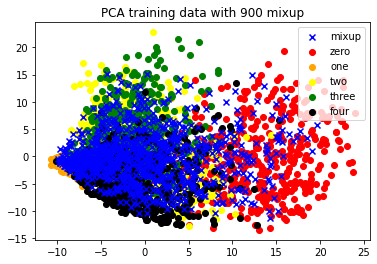

In [131]:
#PCA plot

print(ind)
trainmix = pca.fit_transform(X_train_mix)
ymix = np.argmax(y_train_mix, 1)
print(ymix[0], y_train_mix[0])
print(trainmix.shape, ymix.shape)
#plot
'''col = [0]*len(ymix)
np.where()
col = np.where(ymix<1,'k',np.where(y<5,'b','r'))
'''
mixup = trainmix[:900]
train = trainmix[900:]
mixupy = ymix[:900]
y = ymix[900:]

z,o,t,th,f = train[y ==0], train[y ==1], train[y ==2], train[y ==3], train[y ==4]

#m = plt.scatter(trainmix[900:,0], trainmix[900:,1], c= ymix[900:])

p0 = plt.scatter(z[:,0], z[:,1], marker='o', color='red')
p1 = plt.scatter(o[:,0], o[:,1], marker='o', color='orange')
p2 = plt.scatter(t[:,0], t[:,1], marker='o', color='yellow')
p3 = plt.scatter(th[:,0], th[:,1], marker='o', color='green')
p4 = plt.scatter(f[:,0], f[:,1], marker='o', color='black')

m = plt.scatter(mixup[:,0], mixup[:,1], marker = 'x', color = 'b')

#plt.scatter(mixup[:,0], mixup[:,1], marker='x', color='b')
plt.title('PCA training data with 900 mixup')
plt.legend((m,p0,p1,p2,p3,p4),('mixup', 'zero', 'one','two','three','four'))
plt.show()
